In [269]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True

from IPython.display import clear_output

## Функции

In [2]:
def add_text(ax, text, x, y, alpha_x, alpha_y):
    """
    Adds text to an Axes object at a calculated position based on data ranges and relative positions.

    Args:
    ax (matplotlib.axes.Axes): Target Axes for the text.
    text (str): Text to be added.
    x (array-like): X data to determine positioning.
    y (array-like): Y data to determine positioning.
    alpha_x (float): Relative horizontal position within the data range (0 to 1).
    alpha_y (float): Relative vertical position within the data range (0 to 1).
    
    This function positions text relative to the min and max of provided x and y data,
    adjusted by alpha_x and alpha_y, which scale the text's position within the data bounds.
    """
    # Calculate text position from data bounds and relative positioning
    x_pos = np.min(x) + alpha_x * (np.max(x) - np.min(x))
    y_pos = np.min(y) + alpha_y * (np.max(y) - np.min(y))

    # Add text at calculated position with predefined style
    ax.text(
        x_pos, y_pos, text, fontsize=10, color='black',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 4, 'edgecolor': 'black'}
    )

In [239]:
def gaussian(x, A, mu, sigma, shift):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + shift

def lorentzian(x, A, mu, sigma, shift):
    return A / (1 + 4 * (x - mu)**2 / sigma**2) + shift

def gaussian3(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, shift):
    return A1 * np.exp(-0.5 * ((x - mu1) / sigma1)**2) + A2 * np.exp(-0.5 * ((x - mu2) / sigma2)**2) + A3 * np.exp(-0.5 * ((x - mu3) / sigma3)**2) + shift

def lorentzian3(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, shift):
    return A1 / (1 + 4 * (x - mu1)**2 / sigma1**2) + A2 / (1 + 4 * (x - mu2)**2 / sigma2**2) + A3 / (1 + 4 * (x - mu3)**2 / sigma3**2) + shift

def lorentzian4(x, A0, mu0, sigma0, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, shift):
    return A0 * np.exp(-0.5 * ((x - mu0) / sigma0)**2) + A1 / (1 + 4 * (x - mu1)**2 / sigma1**2) + A2 / (1 + 4 * (x - mu2)**2 / sigma2**2) + A3 / (1 + 4 * (x - mu3)**2 / sigma3**2) + shift

# def lorentzian4(x, A0, mu0, sigma0, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, shift):
#     return A0 / (1 + 4 * (x - mu0)**2 / sigma0**2) + A1 / (1 + 4 * (x - mu1)**2 / sigma1**2) + A2 / (1 + 4 * (x - mu2)**2 / sigma2**2) + A3 / (1 + 4 * (x - mu3)**2 / sigma3**2) + shift

In [167]:
def fit_gaussian(x, y, roi_center, p0_sigma=0.5, roi_size=7, curve=gaussian):
    # fit roi with gaussian curve
    x_min = roi_center - roi_size
    x_max = roi_center + roi_size
    mask = np.logical_and(x > x_min, x < x_max)
    x_roi = x[mask]
    y_roi = y[mask]
    # p0_mu = x_roi[np.argmax(y_roi)]
    p0_mu = roi_center
    popt, pcov = curve_fit(curve, x_roi, y_roi, p0=[np.max(y_roi)-np.min(y_roi), p0_mu, p0_sigma, np.min(y_roi)])

    return popt

def plot_gaussian(ax, x, y, popts, lines, calibration_shift=5.5, yticks=True, roi_size=8):
    roi_center = np.mean(lines) - calibration_shift
    x_min = roi_center - roi_size
    x_max = roi_center + roi_size
    mask = np.logical_and(x > x_min, x < x_max)
    x_roi = x[mask]
    y_roi = y[mask]
    
    x2plot = np.linspace(np.min(x_roi), np.max(x_roi), 1000)
    ax.scatter(x_roi, y_roi, color="blue", alpha=0.5, s=10)
    for popt in popts:
        ax.plot(x2plot, gaussian(x2plot, *popt), color="k", alpha=0.7)
    for line in lines:
        ax.axvline(line, ls="--", color="red", alpha=0.5)
    if not yticks:
        ax.set_yticklabels([])
    ax.grid(alpha=0.5)
    ax.set_ylim(0, 15)
    # ax.set_xlabel(r"$\lambda,\,\mathrm{nm}$")

## Данные

In [11]:
calibration_data_filter = pd.read_csv("data/calibration_filter.csv", header=None, names=["ch1", "ch2"]);
calibration_data_no_filter = pd.read_csv("data/calibration_no_filter.csv", header=None, names=["ch1", "ch2"]);

y_scale = 1e-3
x1 = calibration_data_filter.ch1.to_numpy()
y1 = calibration_data_filter.ch2.to_numpy() * y_scale
x2 = calibration_data_no_filter.ch1.to_numpy()
y2 = calibration_data_no_filter.ch2.to_numpy() * y_scale

## Обработка: calibration

In [12]:
lambda_table = [710, 730, 733, 755, 760, 845, 850]
roi_sizes    = [5,   2,   2,   3,   3,   2,   2]
roi_centers  = [705, 730-5.5, 733-5.5, 748, 754, 837, 842]
popts = [fit_gaussian(x2, y2, center, roi_size=roi_size) for (center, roi_size) in zip(roi_centers, roi_sizes)]

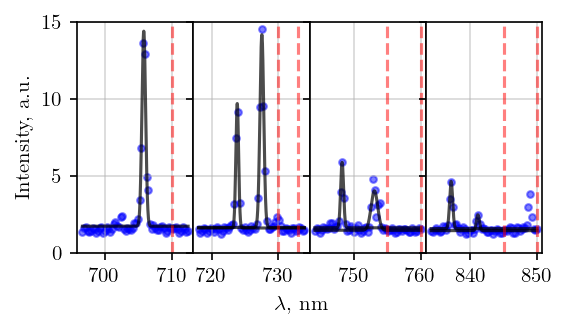

In [214]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(4, 2), dpi=150)

plot_gaussian(ax1, x2, y2, popts[:1], lambda_table[:1])
plot_gaussian(ax2, x2, y2, popts[1:2+1], lambda_table[1:2+1], yticks=False)
plot_gaussian(ax3, x2, y2, popts[3:4+1], lambda_table[3:4+1], yticks=False)
plot_gaussian(ax4, x2, y2, popts[5:6+1], lambda_table[5:6+1], yticks=False)
fig.subplots_adjust(wspace=0)

ax1.set_ylabel("Intensity, a.u.")
fig.text(0.5, -0.08, r"$\lambda,\,\mathrm{nm}$", ha='center')

#  710nm, 730nm, 733nm, 755nm, 760nm, 845nm, 850nm.
# plt.savefig("calibration_gaussian_fits.pdf", bbox_inches='tight')
plt.show()

In [13]:
lambda_exp = [popt[1] for popt in popts]
popt_exp2table = np.polyfit(lambda_exp, lambda_table, 1)
def exp2table(x):
    return np.poly1d(popt_exp2table)(x)
popt_exp2table

array([  1.02563973, -12.91965342])

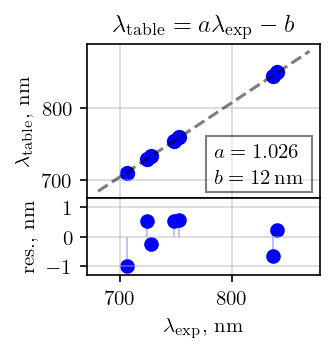

In [212]:
text_message = rf"$\begin{{array}}{{l}} a = {popt_exp2table[0]:.3f}\\ b = {-int(popt_exp2table[1]):.0f}\,\mathrm{{nm}}\end{{array}}$"

x2plot = np.linspace(680, 870, 10)
y2plot = exp2table(x2plot)
rests = np.array(lambda_table) - exp2table(np.array(lambda_exp))

# fig, (ax, ax_r) = plt.subplots(2, 1, figsize=(3, 3), dpi=150)
# Create a figure
fig = plt.figure(figsize=(2, 2), dpi=150)
# Define a gridspec
gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[2, 1])
# Add subplots
ax = fig.add_subplot(gs[0])  # First row, first column
ax_r = fig.add_subplot(gs[1])  # First row, second column

ax.scatter(lambda_exp, lambda_table, color="blue", s=40)
ax.plot(x2plot, y2plot, "--k", alpha=0.5)
ax.grid(alpha=0.5)

ax.set_ylabel(r"$\lambda_{\mathrm{table}},\,\mathrm{nm}$")
add_text(ax, text_message, x2plot, y2plot, 0.55, 0.15)
ax.set_title(r"$\lambda_{\mathrm{table}} = a \lambda_{\mathrm{exp}} - b$")
ax.set_xticklabels([])

ax_r.scatter(lambda_exp, rests, color="blue")
for xi, yi in zip(lambda_exp, rests):
    ax_r.fill_between([xi-1, xi+1], 0, yi, color='blue', alpha=0.25, step='mid', edgecolor='none')
ax_r.grid(alpha=0.5)
ax_r.set_ylabel("res., nm")
ax_r.set_xlim(*ax.get_xlim())
ax_r.set_ylim(-1.3,1.3)
ax_r.set_xlabel(r"$\lambda_{\mathrm{exp}},\,\mathrm{nm}$")
fig.subplots_adjust(hspace=0)
plt.savefig("calibration_linear_fit.pdf", bbox_inches='tight')

plt.show()

## Обработка: quantum dots

In [ ]:
popts = []
for j in range(27, 41+1):

In [76]:
# plt.cm.coolwarm(1-)

In [128]:
df0 = pd.read_csv(f"data/cooling/background_42_4s.csv", header=None, names=["ch1", "ch2"])
x0 = exp2table(df0.ch1.to_numpy())
y0 = df0.ch2.to_numpy() * y_scale

In [200]:
x_roi[np.argmax(y_roi)]

701.643549062045

In [208]:
popt3

array([ 1.71463193e-01,  7.38502278e+02,  4.94551274e+00,  3.13368936e-01,
        7.72195399e+02,  3.04674610e+00,  3.17849794e-01,  7.91232844e+02,
        2.58640623e+00, -2.69072428e-02])

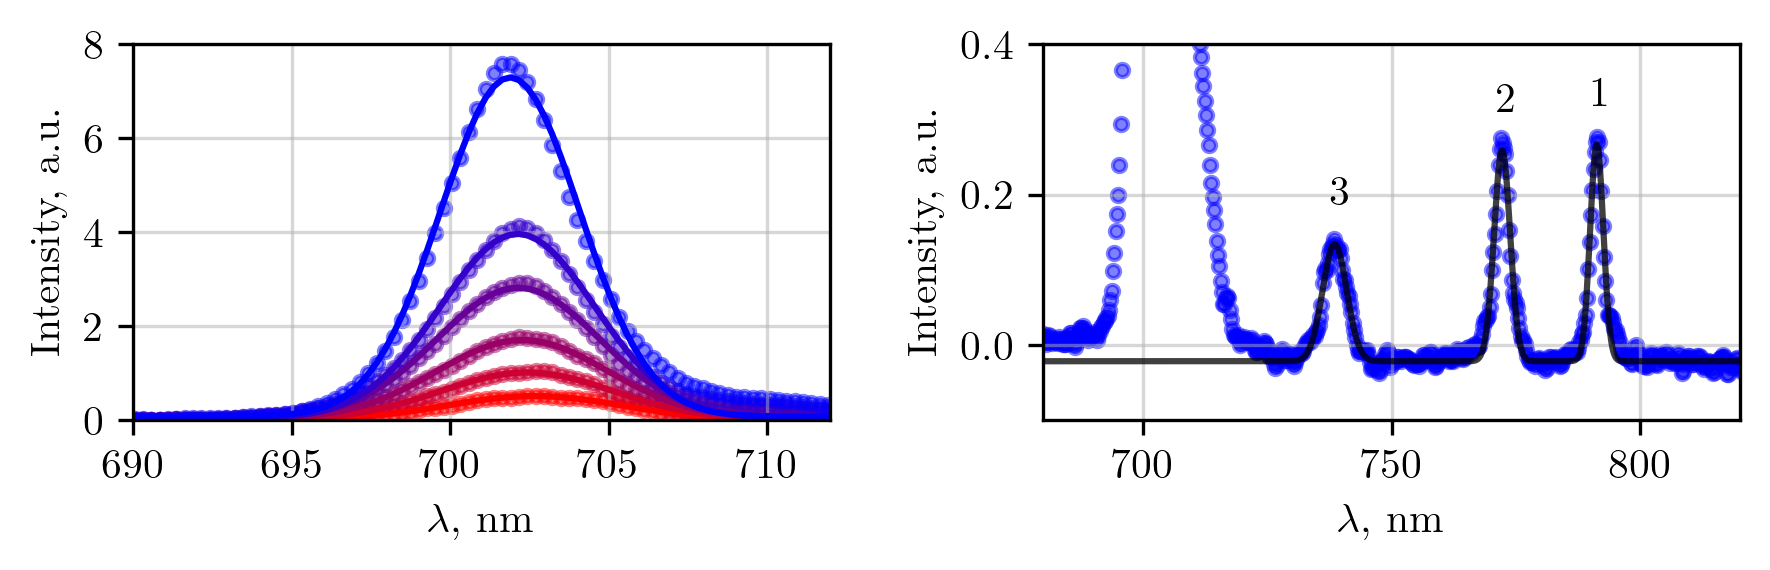

In [298]:
js = [27, 28, 29, 31, 32, 41]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2), dpi=300)

df = pd.read_csv(f"data/cooling/{40}.csv", header=None, names=["ch1", "ch2"])
x = exp2table(df.ch1.to_numpy())
y = df.ch2.to_numpy() * y_scale - y0

mask = np.logical_and(720 < x, x < 900)
x_roi = x[mask]
y_roi = y[mask]
poptX3, _ = curve_fit(gaussian3, x_roi, y_roi, p0=[0.17, 738.5, 4.94, 0.31, 772, 3, 0.32, 791, 2.6, -2.6e-2])



ax2.scatter(x, y, color="blue", s=10, alpha=0.5)
x2plot = np.linspace(680, 900, 1000)
ax2.plot(x2plot, gaussian3(x2plot, *poptX3), color="k", alpha=0.75)

for (i, j) in enumerate(js):
    df = pd.read_csv(f"data/cooling/{j}.csv", header=None, names=["ch1", "ch2"])
    
    x = exp2table(df.ch1.to_numpy())
    y = df.ch2.to_numpy() * y_scale - y0
    popt = fit_gaussian(x, y, 700, 1, 30)
    
    
    beta = i/(len(js)-1)
    ax1.scatter(x, y, color=[1-beta,0,beta], s=10, alpha=0.5)
    ax1.plot(x, gaussian(x, *popt), color=[1-beta,0,beta])


ax1.set_xlim(690, 712)
# ax1.set_xlim(690, 750)
ax1.set_ylim(0, 8)
ax2.set_xlim(680, 820)
ax2.set_ylim(-0.1, 0.4)

for ax in [ax1, ax2]:
    ax.grid(alpha=0.5)
    ax.set_xlabel(r"$\lambda,\,\mathrm{nm}$")
    ax.set_ylabel(r"Intensity, a.u.")

for i in range(3):
    ax2.text(poptX3[1+3*i]-1,poptX3[0+3*i]+0.03,3-i)

# fig.subplots_adjust(wspace=200000)
plt.tight_layout()
plt.savefig("T_dep.pdf", bbox_inches='tight')
plt.show()

In [288]:
for i in range(3):
    print(3-i, f"{poptX3[1+3*i]:.2f}")

3 738.54
2 772.20
1 791.22


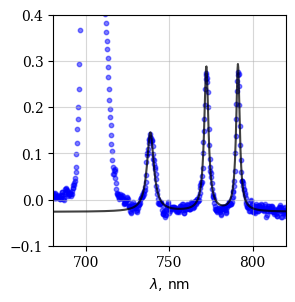

In [251]:
j = 40

plt.figure(figsize=(3,3))

df = pd.read_csv(f"data/cooling/{40}.csv", header=None, names=["ch1", "ch2"])

x = exp2table(df.ch1.to_numpy())
y = df.ch2.to_numpy() * y_scale - y0
# popt1 = fit_gaussian(x, y, 740, 1, 10)
# popt2 = fit_gaussian(x, y, 772, 1, 10)
# popt3 = fit_gaussian(x, y, 790, 1, 10)

mask = np.logical_and(720 < x, x < 900)
x_roi = x[mask]
y_roi = y[mask]
# popt3, _ = curve_fit(lorentzian3, x_roi, y_roi, p0=[0.17, 738.5, 4.94, 0.31, 772, 3, 0.32, 791, 2.6, -2.6e-2])
# popt3, _ = curve_fit(gaussian3, x_roi, y_roi, p0=[0.17, 738.5, 4.94, 0.31, 772, 3, 0.32, 791, 2.6, -2.6e-2])
# popt4, _ = curve_fit(lorentzian4, x_roi, y_roi, p0=[6.85, 701.8, 2.29, 0.17, 738.5, 4.94, 0.31, 772, 3, 0.32, 791, 2.6, -2.6e-2])

beta = i/(len(js)-1)
plt.scatter(x, y, color="blue", s=10, alpha=0.5)

x2plot = np.linspace(680, 900, 1000)
# plt.plot(x2plot, gaussian(x2plot, *popt1)+gaussian(x2plot, *popt2)+gaussian(x2plot, *popt3), color="k", alpha=0.75)
# plt.plot(x2plot, lorentzian(x2plot, *popt1)+lorentzian(x2plot, *popt2)+lorentzian(x2plot, *popt3), color="k", alpha=0.75)
# plt.plot(x2plot, lorentzian3(x2plot, *popt3), color="k", alpha=0.75)
# plt.plot(x2plot, gaussian3(x2plot, *popt3), color="k", alpha=0.75)
# plt.plot(x2plot, lorentzian4(x2plot, *popt4), color="k", alpha=0.75)

plt.xlim(680, 820)
# plt.xlim(680, 740)
plt.ylim(-0.1, 0.4)
plt.grid(alpha=0.5)
plt.xlabel(r"$\lambda,\,\mathrm{nm}$")
# plt.title("lorentz")
plt.show()

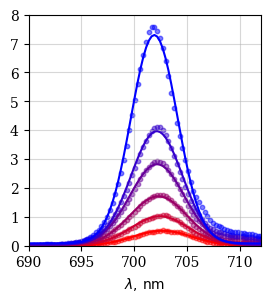

In [253]:
js = [27, 28, 29, 31, 32, 41]

plt.figure(figsize=(3,3))
for (i, j) in enumerate(js):
    df = pd.read_csv(f"data/cooling/{j}.csv", header=None, names=["ch1", "ch2"])
    
    x = exp2table(df.ch1.to_numpy())
    y = df.ch2.to_numpy() * y_scale - y0
    popt = fit_gaussian(x, y, 700, 1, 30)
    
    
    beta = i/(len(js)-1)
    plt.scatter(x, y, color=[1-beta,0,beta], s=10, alpha=0.5)
    plt.plot(x, gaussian(x, *popt), color=[1-beta,0,beta])


plt.xlim(690, 712)
plt.ylim(0, 8)
plt.grid(alpha=0.5)
plt.xlabel(r"$\lambda,\,\mathrm{nm}$")
plt.show()

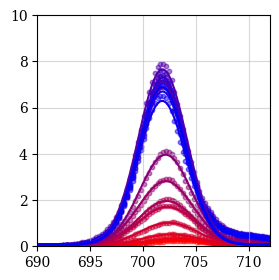

In [132]:
js = np.arange(25, 41, 1)
mus    = [0] * len(js)
sigmas = [0] * len(js)

plt.figure(figsize=(3,3))
for (i, j) in enumerate(js):
    df = pd.read_csv(f"data/cooling/{j}.csv", header=None, names=["ch1", "ch2"])
    
    x = exp2table(df.ch1.to_numpy())
    y = df.ch2.to_numpy() * y_scale - y0
    popt = fit_gaussian(x, y, 702, 1, 30)

    mus[i] = popt[1]
    sigmas[i] = popt[2]
    
    
    beta = i/(len(js)-1)
    plt.scatter(x, y, color=[1-beta,0,beta], s=10, alpha=0.5)
    plt.plot(x, gaussian(x, *popt), color=[1-beta,0,beta])


plt.xlim(690, 712)
plt.ylim(0, 10)
plt.grid(alpha=0.5)
plt.show()

Text(0, 0.5, 'sigma')

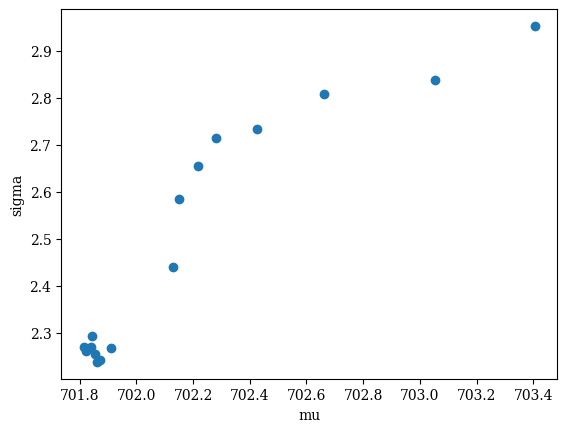

In [255]:
plt.scatter(mus, sigmas)
plt.xlabel("mu")
plt.ylabel("sigma")

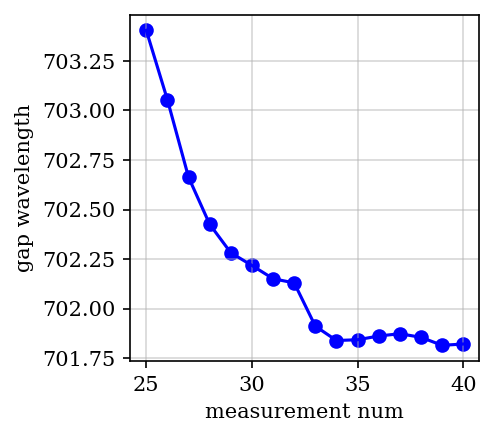

In [134]:
plt.figure(figsize=(3,3), dpi=150)
plt.scatter(js, mus, color="blue")
plt.plot(js, mus, color="blue")
plt.xlabel("measurement num")
plt.ylabel("gap wavelength")
plt.grid(alpha=0.5)
plt.show()

701.8874952404094


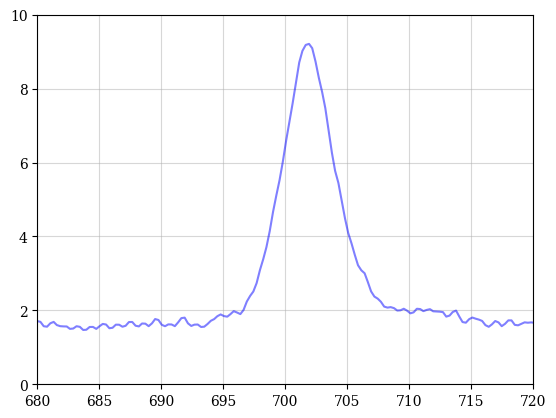

In [54]:
j = 41;
df = pd.read_csv(f"data/cooling/{j}.csv", header=None, names=["ch1", "ch2"])

x = exp2table(df.ch1.to_numpy())
y = df.ch2.to_numpy() * y_scale

mask = np.logical_and(670 < x, x < 730)
popt = fit_gaussian(x, y, 700, 1, 30)
x_roi = x[mask]
y_roi = y[mask]

print(popt[1])
plt.plot(x_roi, y_roi, color="blue", alpha=0.5)
plt.plot(x_roi, gaussian(x_roi, *popt), "k", alpha=0.75)
plt.xlim(680, 720)
plt.ylim(0, 10)
plt.grid(alpha=0.5)
plt.show()